# K-Means Clustering: Spending Score vs Age
Focus: quick, single experiment to cluster mall customers using only Age and Spending Score.
- Dataset: Mall Customers (Spending Score 1-100, Age in years).
- Steps: load + clean, visualize the 2D data, run a baseline model, use an elbow plot to choose k, retrain and visualize.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

plt.style.use("seaborn-v0_8-whitegrid")
RANDOM_STATE = 42


def plot_clusters(points, labels, centers, title):
    plt.figure(figsize=(8, 5))
    plt.scatter(points[:, 0], points[:, 1], c=labels, cmap="tab10", s=40, alpha=0.8)
    plt.scatter(centers[:, 0], centers[:, 1], marker="*", color="black", s=180, edgecolor="white", linewidths=1.5)
    plt.title(title)
    plt.xlabel("Age")
    plt.ylabel("Spending Score")
    plt.grid(True, alpha=0.4)
    plt.show()


In [ ]:
url = "https://raw.githubusercontent.com/schauppi/Intro_ML/main/datasets/Mall_Customers.csv"

data = pd.read_csv(url)

data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Drop ID (not useful for clustering) and rename for nicer column names
customers = data.drop(columns=["CustomerID"])
customers = customers.rename(columns={"Annual Income (k$)": "Annual_Income", "Spending Score (1-100)": "Spending_Score"})
customers.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Quick data check
Get a feel for the columns and types before clustering.


In [ ]:
customers.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          200 non-null    object
 1   Age             200 non-null    int64 
 2   Annual_Income   200 non-null    int64 
 3   Spending_Score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


## Spending Score vs Age
Plot the 2D feature space we'll cluster.


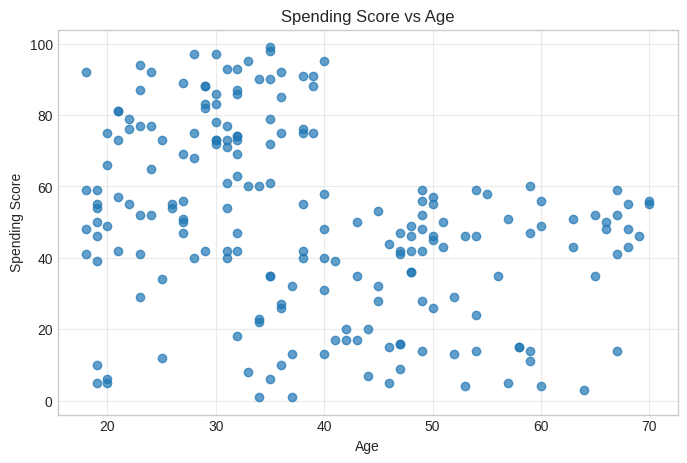

In [ ]:
features = customers[["Age", "Spending_Score"]].values

plt.figure(figsize=(8, 5))
plt.scatter(features[:, 0], features[:, 1], alpha=0.7, color="#1f77b4")
plt.title("Spending Score vs Age")
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.grid(True, alpha=0.4)
plt.show()


## Baseline K-Means (k=3)
Start with a simple choice of 3 clusters to see initial groupings.


- **`n_clusters=baseline_k`**:  
  This argument specifies the number of clusters (*k*) that the K-Means algorithm will attempt to form. In this particular case, `baseline_k` is set to 3, meaning the model will try to group the data into **3 distinct clusters**.

- **`n_init=10`**:  
  The K-Means algorithm is sensitive to the initial placement of centroids. To mitigate this, `n_init` determines how many times the K-Means algorithm will be run with different centroid seeds. The final result will be the best output of `n_init` consecutive runs in terms of inertia (WCSS).

- **`random_state=RANDOM_STATE`**:  
  This argument sets the seed for the random number generator used for centroid initialization. Setting a `random_state` (to a fixed number like 42, in this case) ensures that the results are reproducible. If you run the code multiple times with the same `random_state`, you will get the exact same cluster assignments and centroids.

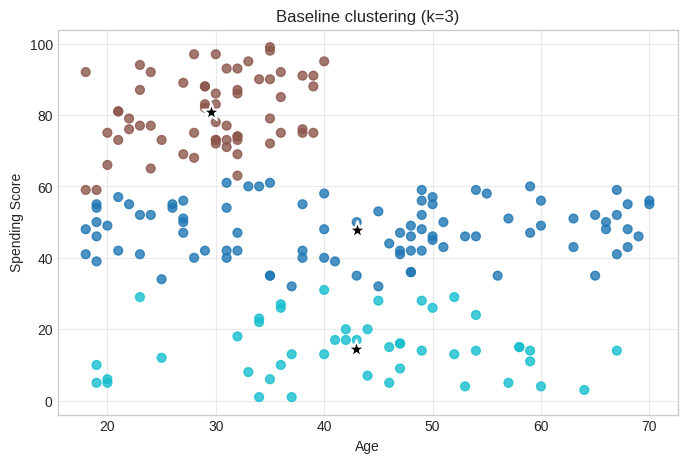

In [ ]:
baseline_k = 3
baseline_model = KMeans(n_clusters=baseline_k, n_init=10, random_state=RANDOM_STATE)
baseline_labels = baseline_model.fit_predict(features)

plot_clusters(features, baseline_labels, baseline_model.cluster_centers_, f"Baseline clustering (k={baseline_k})")


## Pick k with an elbow plot
Compute WCSS for different k values and pick the elbow automatically (second-derivative heuristic).


*   **Iterating through 'k' values**: It calculates the K-Means model for a range of `k` values (from 1 to 10 in this case). For each `k`, it computes the **Within-Cluster Sum of Squares (WCSS)**, which measures the sum of squared distances between each point and its assigned cluster centroid. A smaller WCSS generally means denser clusters.
*   **Identifying the 'elbow'**: The `estimate_elbow` function attempts to automatically find the 'elbow' point on the WCSS curve. This point is where the rate of decrease in WCSS significantly slows down, suggesting that adding more clusters beyond this point provides diminishing returns in terms of compactness.
*   **Visualizing the Elbow Plot**: Finally, it generates a plot with `k` on the x-axis and WCSS on the y-axis. The plot helps visually confirm the 'elbow' – a point that looks like an elbow, indicating the recommended `k`. A red dashed line highlights the `best_k` value identified by the heuristic.

Elbow heuristic suggests k=5


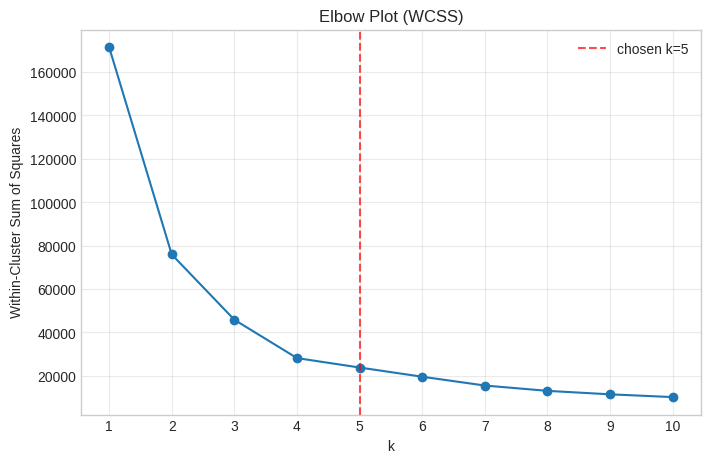

In [ ]:
k_values = range(1, 11)
wcss = []

for k in k_values:
    model = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    model.fit(features)
    wcss.append(model.inertia_)

def estimate_elbow(values):
    if len(values) < 3:
        return None
    first_diff = np.diff(values)
    second_diff = np.diff(first_diff)
    return int(np.argmin(second_diff) + 2)

best_k = estimate_elbow(wcss) or baseline_k
print(f"Elbow heuristic suggests k={best_k}")

plt.figure(figsize=(8, 5))
plt.plot(list(k_values), wcss, marker="o")
plt.title("Elbow Plot (WCSS)")
plt.xlabel("k")
plt.ylabel("Within-Cluster Sum of Squares")
plt.xticks(list(k_values))
plt.grid(True, alpha=0.4)
plt.axvline(best_k, color="red", linestyle="--", alpha=0.7, label=f"chosen k={best_k}")
plt.legend()
plt.show()


## Final model with chosen k
Retrain using the elbow-selected k and visualize the resulting clusters.


*   **`final_model = KMeans(...)`**: Initializes a new K-Means model, but this time with `n_clusters=best_k` (which was found to be 5 in this case). The `n_init=10` and `random_state=RANDOM_STATE` parameters ensure reproducibility and better cluster formation.
*   **`final_labels = final_model.fit_predict(features)`**: Fits the K-Means model to your `features` data and assigns each data point to a cluster. The `final_labels` array contains the cluster ID for each data point.
*   **`plot_clusters(...)`**: Calls the custom `plot_clusters` function (defined earlier) to display the clustered data. Each cluster is colored differently, and the black stars indicate the centroids of these final clusters. This visualization helps you understand the segments identified by the K-Means algorithm.

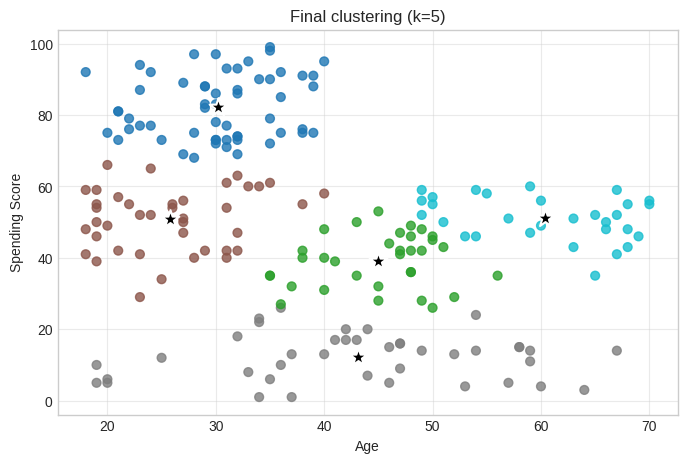

In [ ]:
final_model = KMeans(n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)
final_labels = final_model.fit_predict(features)

plot_clusters(features, final_labels, final_model.cluster_centers_, f"Final clustering (k={best_k})")
